In [1]:
import sys
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('functions')
from data_frame_handler import DataFrameHandler as dfh

# main path to file with data. Can be easily changed
file_path = 'data/urine_test_data.csv'

Step 0: Data prep

In [2]:
df = dfh.read_csv_data(file_path)

# Use a list comprehension to dynamically select matching columns
organisms = dfh.select_columns_by_search_terms(df, ['organism'])
genes = dfh.select_columns_by_search_terms(df, ['gene'])
antibiotics = dfh.select_columns_by_search_terms(df, ['antibiotic'])

# Set the 'Type' column to the values in gene_data_str - FUTURE Labels
gene_data_str = df[genes].applymap(str).agg(''.join, axis=1)
df['Type'] = gene_data_str

In [3]:
# Get a colormap based on the number of unique 'Type' values
geneset_unique_types = df['Type'].unique()
num_unique_types = len(geneset_unique_types)
cmap = plt.get_cmap('tab20', num_unique_types)

# Create a mapping of 'Type' values to colors
type_colors = {type_value: cmap(i) for i, type_value in enumerate(geneset_unique_types)}

# Map 'Type' values to colors in a new Series
type_colors_series = df['Type'].map(type_colors)

Let's probe around with just Org1 and Anti1 for a bit to 
get a feel of prior distribution specification

In [4]:
organisms = dfh.select_columns_by_search_terms(df, ['Organism_2'] )
antibiotics = dfh.select_columns_by_search_terms(df, ['Antibiotic_2'])

Organism_2 vs Antibiotic_2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


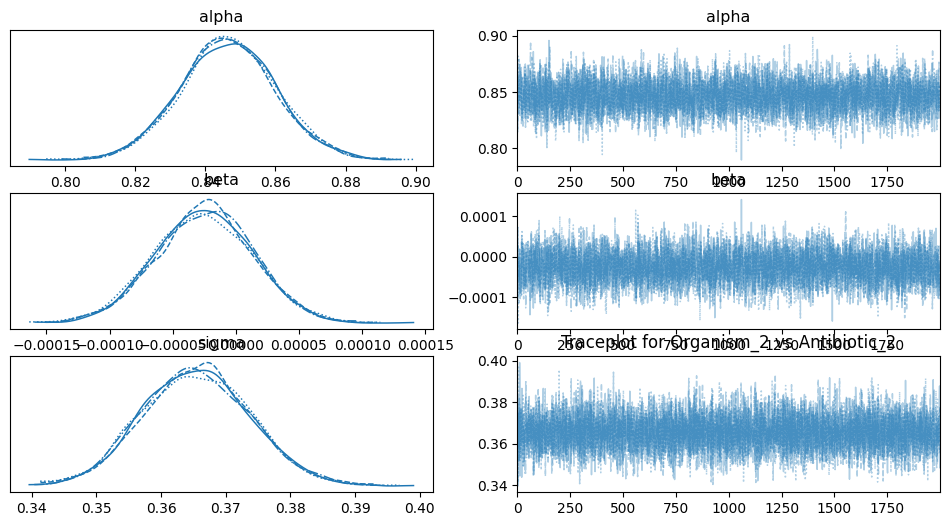

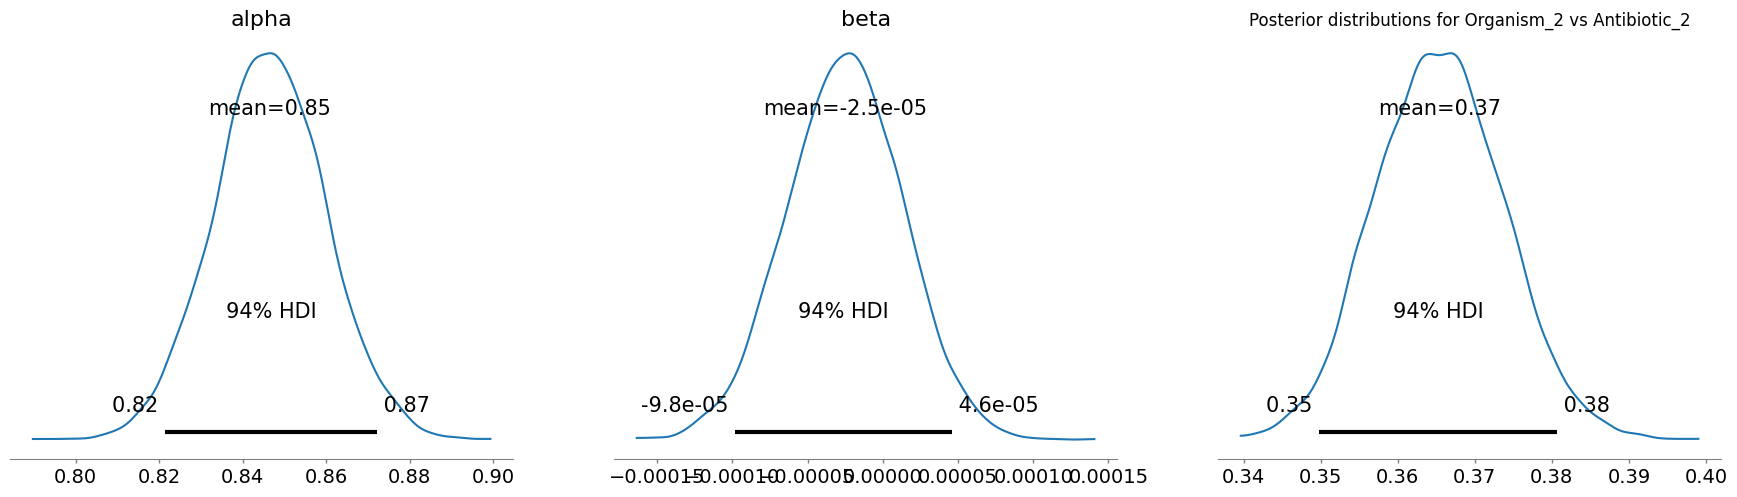

Sampling: [y]


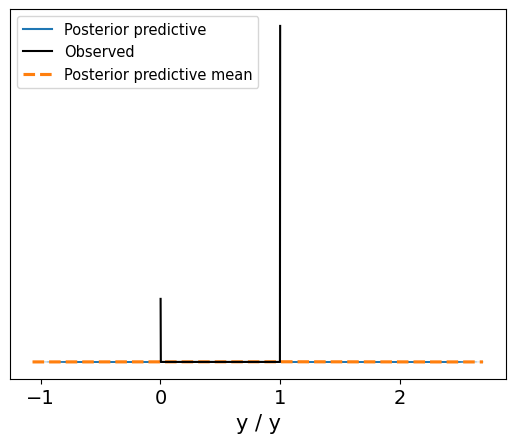

In [6]:
# Iterate through pairs of organisms and antibiotics
for org, anti in zip(organisms, antibiotics):

    print(f"{org} vs {anti}")
    
    # Extract data for the current pair
    X = df[org].values.astype(float)
    y = df[anti].replace({'R': 1, 'S': 0}).values
    
    # Bayesian Linear Regression Model
    with pm.Model() as model:
        
        # Priors
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10)
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # Likelihood
        mu = alpha + beta * X
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
        
        # MCMC
        trace = pm.sample(2000, tune=1000, chains=4)

        # for a well-converged chain, rhat should be close to 1.0.
        pm.summary(trace).round(2)

        # Visualization
        # Trace plot
        pm.plot_trace(trace)
        plt.title(f"Traceplot for {org} vs {anti}")
        plt.show()
        
        # Posterior plot
        pm.plot_posterior(trace)
        plt.title(f"Posterior distributions for {org} vs {anti}")
        plt.show()

        # Generate posterior predictive samples
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"])
        pm.plot_ppc(data=posterior_predictive)
        plt.show()

Organism_2 vs Antibiotic_2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


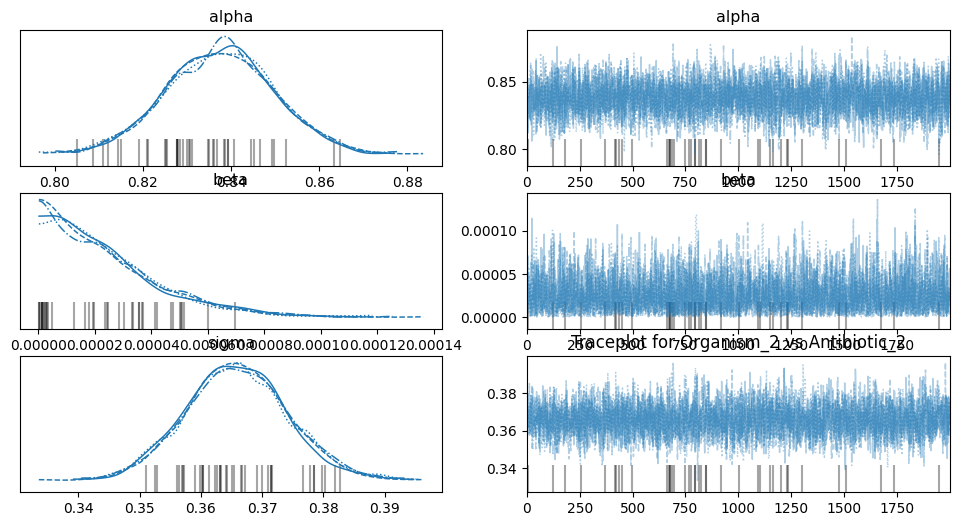

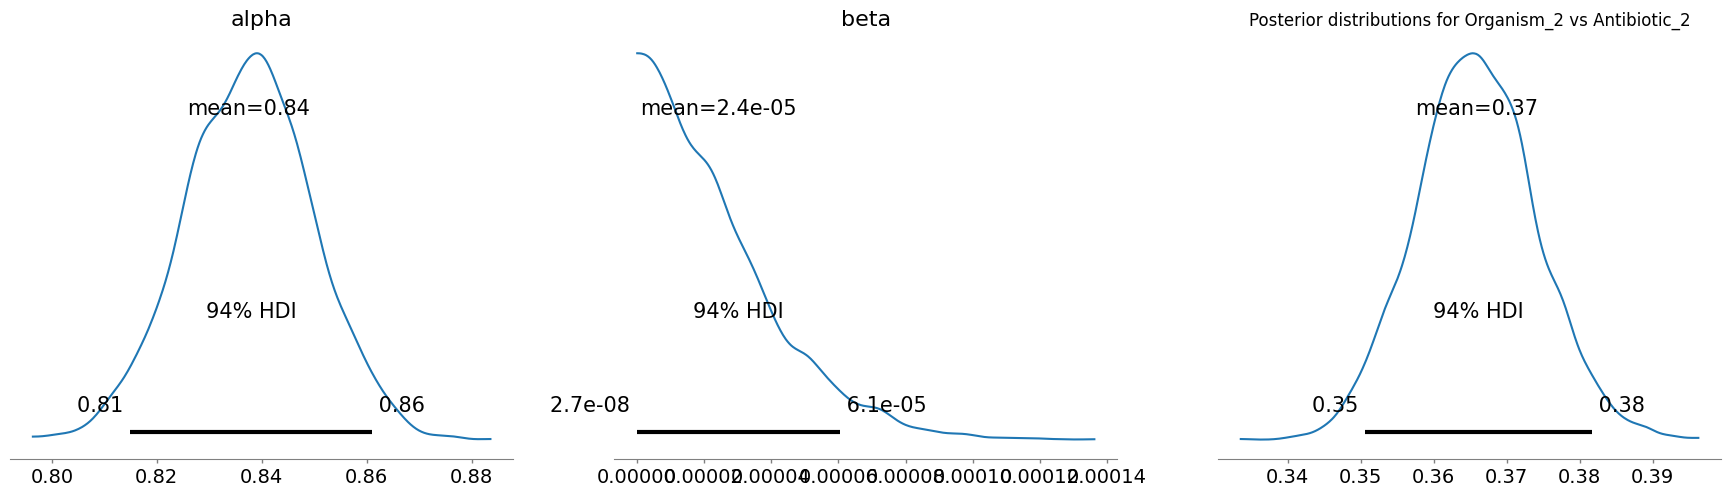

Sampling: [y]


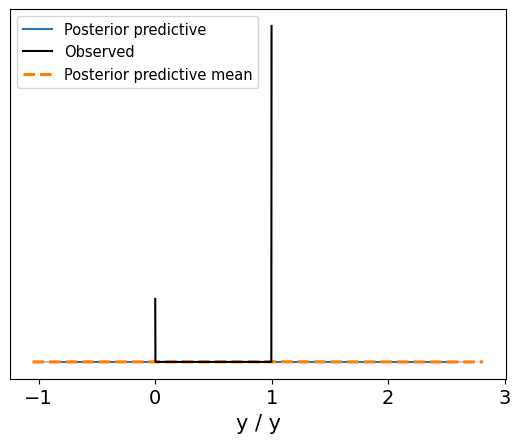

In [9]:
# Iterate through pairs of organisms and antibiotics
for org, anti in zip(organisms, antibiotics):
    print(f"{org} vs {anti}")
    
    # Extract data for the current pair
    X = df[org].values.astype(float)
    y = df[anti].replace({'R': 1, 'S': 0}).values
    
    # Bayesian Linear Regression Model
    with pm.Model() as model:

        # Updated Priors
        alpha = pm.Uniform('alpha', lower=-10, upper=10)
        beta = pm.Exponential('beta', lam=1)
        sigma = pm.HalfCauchy('sigma', beta=2.5)
        
        # Likelihood
        mu = alpha + beta * X
        likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
        
        # MCMC
        trace = pm.sample(2000, tune=1000, chains=4)

        # for a well-converged chain, rhat should be close to 1.0.
        pm.summary(trace).round(2)

        # Visualization
        # Trace plot
        pm.plot_trace(trace)
        plt.title(f"Traceplot for {org} vs {anti}")
        plt.show()
        
        # Posterior plot
        pm.plot_posterior(trace)
        plt.title(f"Posterior distributions for {org} vs {anti}")
        plt.show()

        # Generate posterior predictive samples
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"])
        pm.plot_ppc(data=posterior_predictive)
        plt.show()

In [ ]:
# Iterate through pairs of organisms and antibiotics
for org, anti in zip(organisms, antibiotics):
    print(f"{org} vs {anti}")

    # Extract data for the current pair
    X = df[org].apply(lambda x: 1 if x > 0 else 0)
    X = X.values.astype(float)
    y = df[anti].replace({'R': 1, 'S': 0}).values
    
    with pm.Model() as model:
        
        # Priors
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[0])
        
        # Logistic function
        mu = alpha + pm.math.dot(X, beta)
        p = pm.math.invlogit(mu)  # Logistic function transforms mu to [0, 1]
        
        # Likelihood
        likelihood = pm.Bernoulli('y', p=p, observed=y)
        
        # Sampling
        trace = pm.sample(2000, tune=1000)

        # for a well-converged chain, rhat should be close to 1.0.
        pm.summary(trace).round(2)

        # Visualization
        # Trace plot
        pm.plot_trace(trace)
        plt.title(f"Traceplot for {org} vs {anti}")
        plt.show()
        
        # Posterior plot
        pm.plot_posterior(trace)
        plt.title(f"Posterior distributions for {org} vs {anti}")
        plt.show()

        # Generate posterior predictive samples
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"])
        pm.plot_ppc(data=posterior_predictive)
        plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Select subset of data to investigate
['Organism_1', 'Organism_2', 'Organism_3']
['Antibiotic_1', 'Antibiotic_2', 'Antibiotic_3']

Let's go with the binary distribution as that has been most effective so far

In [ ]:
organisms = dfh.select_columns_by_search_terms(df, ['Organism_1', 'Organism_2', 'Organism_3'] )
antibiotics = dfh.select_columns_by_search_terms(df, ['Antibiotic_1', 'Antibiotic_2', 'Antibiotic_3'])

In [ ]:
# Iterate through pairs of organisms and antibiotics
for org, anti in zip(organisms, antibiotics):
    print(f"{org} vs {anti}")

    # Extract data for the current pair
    X = df[org].apply(lambda x: 1 if x > 0 else 0)
    X = X.values.astype(float)
    y = df[anti].replace({'R': 1, 'S': 0}).values
    
    with pm.Model() as model:
        
        # Priors
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[0])
        
        # Logistic function
        mu = alpha + pm.math.dot(X, beta)
        p = pm.math.invlogit(mu)  # Logistic function transforms mu to [0, 1]
        
        # Likelihood
        likelihood = pm.Bernoulli('y', p=p, observed=y)
        
        # Sampling
        trace = pm.sample(2000, tune=1000)

        # for a well-converged chain, rhat should be close to 1.0.
        pm.summary(trace).round(2)

        # Visualization
        # Trace plot
        pm.plot_trace(trace)
        plt.title(f"Traceplot for {org} vs {anti}")
        plt.show()
        
        # Posterior plot
        pm.plot_posterior(trace)
        plt.title(f"Posterior distributions for {org} vs {anti}")
        plt.show()

        # Generate posterior predictive samples
        posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"])
        pm.plot_ppc(data=posterior_predictive)
        plt.show()